## Imports

In [17]:
import os
import sunpy.map
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from typing import Tuple, Dict
from skimage.transform import resize  # Importar resize de scikit-image
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score

##  Ruta a las IMG

In [47]:
# Ruta base a tus imágenes
base_data_path = "/home/alyonaivanova/personal/SOLAR/data/multichannel_SDO_AIA/"
print(f"Files in directory: {os.listdir(base_data_path)}")

Files in directory: ['171.0Å', '131.0Å', '211.0Å', '1700.0Å', '304.0Å', '4500.0Å', '335.0Å', '1600.0Å', '193.0Å']


In [48]:
channel_properties = {
    "131.0Å": {"cmap": "Blues", "description": "10 million K (Flare Plasma)"},
    "171.0Å": {"cmap": "YlGnBu", "description": "1 million K (Quiet Corona)"},
    "193.0Å": {"cmap": "Oranges", "description": "1.25 million K (Active Corona)"},
    "211.0Å": {"cmap": "Reds", "description": "2 million K (Hot Corona)"},
    "304.0Å": {"cmap": "PuRd", "description": "50,000 K (Chromosphere/Transition Region)"},
    "335.0Å": {"cmap": "Purples", "description": "2.5 million K (Active Region Corona)"},
    "1600.0Å": {"cmap": "pink", "description": "6,000 K (Transition Region)"},
    "1700.0Å": {"cmap": "Greys", "description": "5,000 K (Photosphere)"},
    "4500.0Å": {"cmap": "coolwarm", "description": "6,000 K (Photosphere Continuum)"}
}

In [62]:
def load_fits_data(channel_dir: str):
    """
    Carga datos FITS y metadatos desde el directorio especificado.
    """
    fits_files = [f for f in os.listdir(channel_dir) if f.endswith(".fits")]
    if not fits_files:
        raise FileNotFoundError(f"No FITS files found in directory: {channel_dir}")
    
    fits_path = os.path.join(channel_dir, fits_files[0])
    aia_map = sunpy.map.Map(fits_path)
    return aia_map.data, aia_map.meta

##  **Creacion de la Mascara**

Observamos que los pixeles afuera del disco solar solo generaran ruido, entonces para
solucionar est voamos a implementar una máscara circular para eliminar los píxeles que no pertenecen
al disco solar. Usaremos la tabla de metadatos para determinar el radio del Sol en 
píxeles y crear la máscara.


### Pasos
1. **Calcular el radio del Sol en píxeles**:
   - Usamos el metadato `R_SUN` y la escala en píxeles (`CDELT1` o `CDELT2`).
2. **Crear la máscara circular**:
   - Usaremos la ecuación del círculo:
     \[
     (x - x_{\text{centro}})^2 + (y - y_{\text{centro}})^2 < R^2
     \]
3. **Aplicar la máscara**:
   - Establecemos los píxeles fuera del círculo como `NaN` o `0`.

In [50]:
def create_circular_mask(data, metadata):
    """
    Crea una máscara circular adaptada al disco solar en los datos.
    """
    ny, nx = data.shape
    x_center = nx // 2
    y_center = ny // 2
    
    # Determinar el radio del Sol en píxeles usando cdelt1 y cdelt2
    cdelt1 = metadata.get("cdelt1", 1.0)  # Arcsec/píxel en X
    solar_radius_arcsec = metadata.get("rsun_obs", 960.0)  # Radio solar en arcsec
    solar_radius_pixels = int(solar_radius_arcsec / abs(cdelt1))  
    # Usamos abs() por si cdelt1 es negativo

    print(f"Metadata for channel: CDELT1={cdelt1}, RSUN_OBS={solar_radius_arcsec}")
    print(f"Solar radius in pixels: {solar_radius_pixels}")

    # Crear las coordenadas de la malla
    y, x = np.ogrid[:ny, :nx]
    distance_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)

    # Crear la máscara
    mask = distance_from_center <= solar_radius_pixels
    return mask

In [51]:
def preprocess_image(data: np.ndarray, mask: np.ndarray, size: int = 512) -> np.ndarray:
    """
    Resize the image to the specified size and apply the circular mask.

    Args:
        data (np.ndarray): Original solar image data.
        mask (np.ndarray): Circular mask array.
        size (int): Desired size for resizing the image (default: 512).

    Returns:
        np.ndarray: Masked and resized image data.
    """
    # Redimensionar los datos usando interpolación
    resized_data = resize(data, (size, size), mode="reflect", anti_aliasing=True)
    
    # Redimensionar la máscara sin anti_aliasing (ya que es booleana)
    resized_mask = resize(mask, (size, size), mode="reflect", anti_aliasing=False) > 0.5  
    # Binarizar la máscara

    # Aplicar la máscara a los datos redimensionados
    masked_data = resized_data.copy()
    masked_data[~resized_mask] = np.nan  # Enmascarar píxeles fuera del disco solar

    return masked_data

Channel: 131.0Å, Data Stats: min=-8.0,max=546.0
Metadata for channel: CDELT1=0.600698, RSUN_OBS=950.956744
Solar radius in pixels: 1583
Channel: 171.0Å, Data Stats: min=-8.0,max=2606.0
Metadata for channel: CDELT1=0.599489, RSUN_OBS=950.956708
Solar radius in pixels: 1586
Channel: 193.0Å, Data Stats: min=-8.0,max=3685.0
Metadata for channel: CDELT1=0.600714, RSUN_OBS=950.956396
Solar radius in pixels: 1583
Channel: 211.0Å, Data Stats: min=-8.0,max=1832.0
Metadata for channel: CDELT1=0.600758, RSUN_OBS=950.956121
Solar radius in pixels: 1582
Channel: 304.0Å, Data Stats: min=-8.0,max=224.0
Metadata for channel: CDELT1=0.600165, RSUN_OBS=950.956768
Solar radius in pixels: 1584
Channel: 335.0Å, Data Stats: min=-8.0,max=982.0
Metadata for channel: CDELT1=0.600737, RSUN_OBS=950.956839
Solar radius in pixels: 1582
Channel: 1600.0Å, Data Stats: min=-8.0,max=7956.0
Metadata for channel: CDELT1=0.609373, RSUN_OBS=950.956624
Solar radius in pixels: 1560
Channel: 1700.0Å, Data Stats: min=-8.0,max=

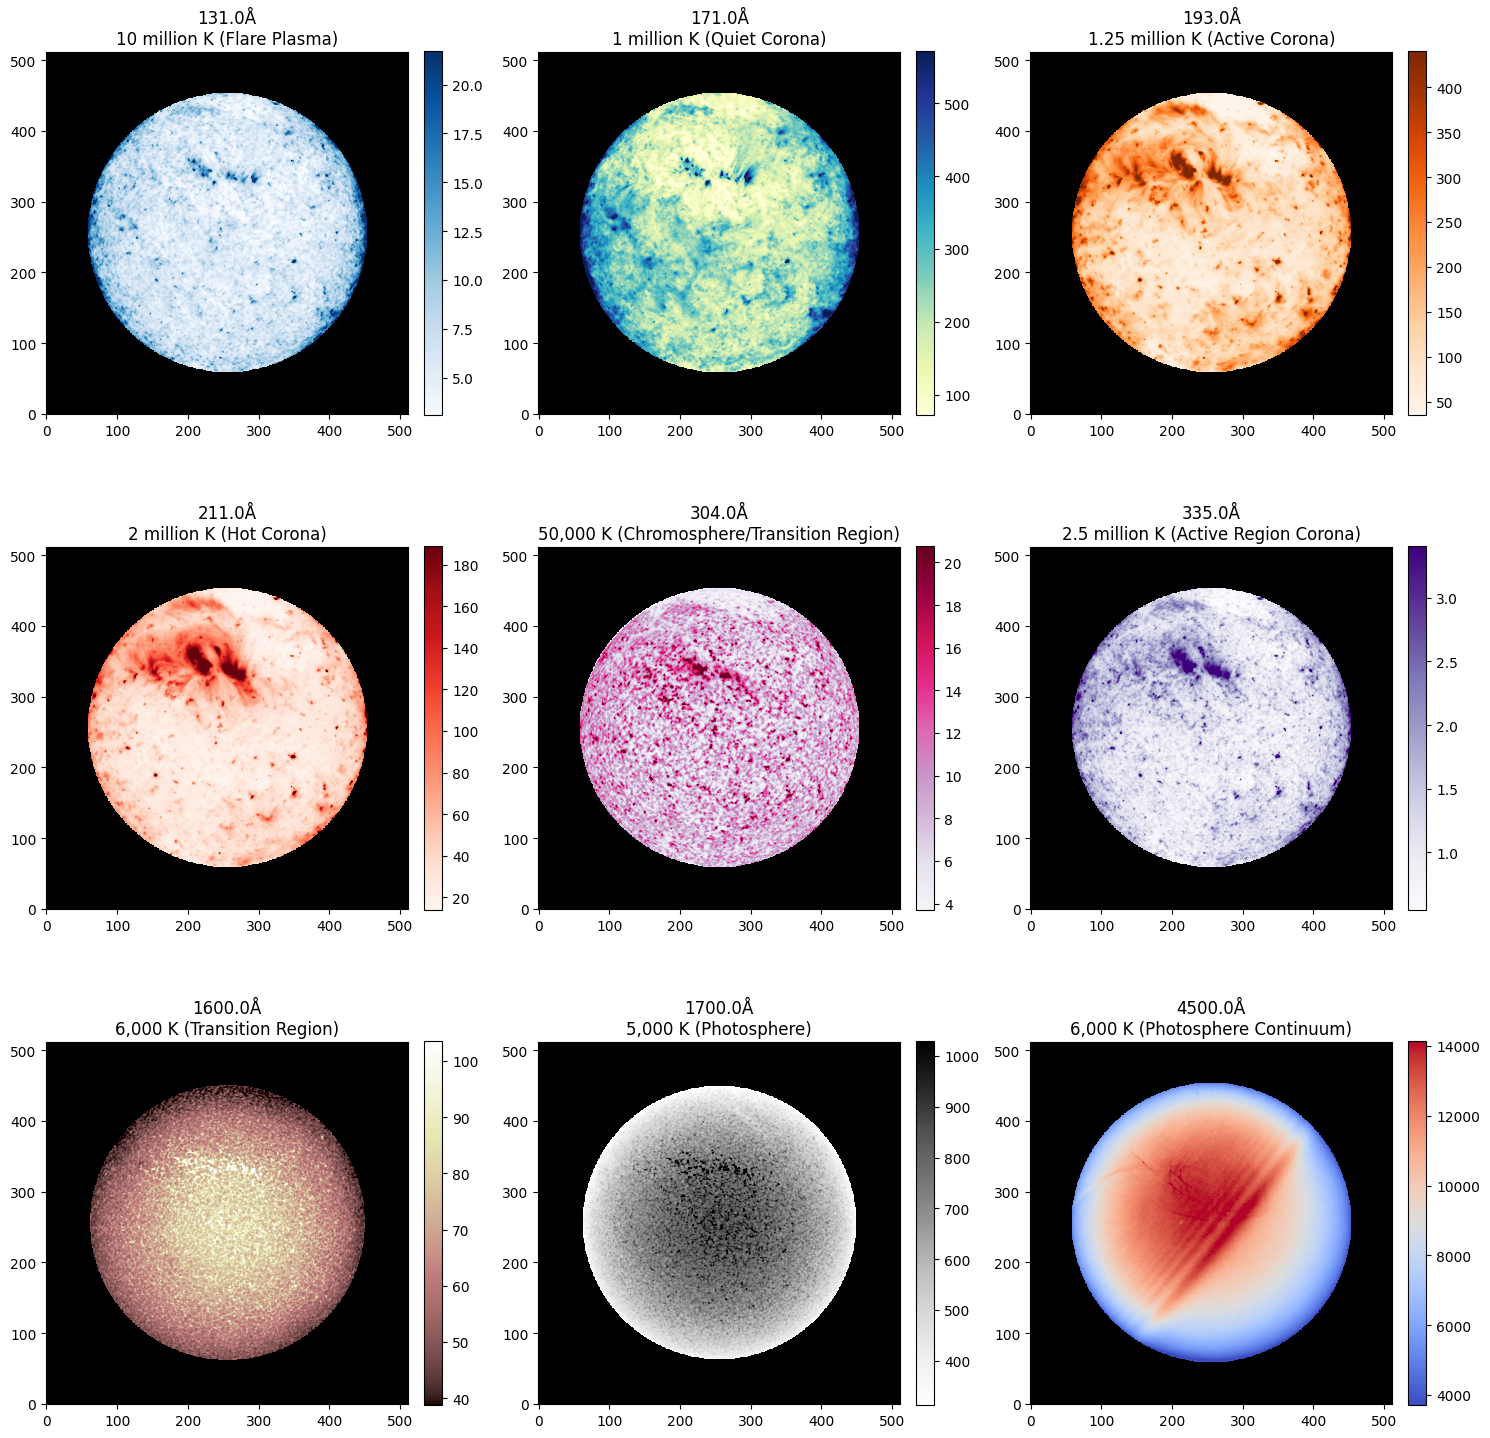

In [53]:
def plot_channel(ax: plt.Axes, channel: str,
                 masked_data: np.ndarray, 
                 channel_properties: dict):
    """
    Plot the processed channel data.

    Args:
        ax (plt.Axes): Matplotlib axis for plotting.
        channel (str): Name of the solar channel.
        masked_data (np.ndarray): Processed and masked image data.
        channel_properties (dict): Properties for each channel (e.g., colormap, description).
    """
    vmin, vmax = np.nanpercentile(masked_data, [1, 99])
    props = channel_properties.get(channel, {"cmap": "gray", "description": "Unknown"})
    ax.set_facecolor("black")
    im = ax.imshow(masked_data, origin="lower", cmap=props["cmap"], vmin=vmin, vmax=vmax)
    ax.set_title(f"{channel}\n{props['description']}", color="Black")
    plt.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)

# Crear figura para mostrar los canales
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
fig.patch.set_facecolor("white")

# Procesar cada canal
for i, channel in enumerate(channel_properties.keys()):
    channel_dir = os.path.join(base_data_path, channel)
    try:
        # Cargar datos y metadatos
        channel_data, metadata = load_fits_data(channel_dir)
        print(f"Channel: {channel}, Data Stats: min={np.nanmin(channel_data)},max={np.nanmax(channel_data)}")
        
        # Crear máscara circular
        mask = create_circular_mask(channel_data, metadata)

        # Preprocesar la imagen
        masked_data = preprocess_image(channel_data, mask)
        # Verificar si los datos no están completamente enmascarados
        if np.isnan(masked_data).all():
            print(f"Channel {channel}: All data masked.")
            axes[i].set_title(f"{channel} (All Data Masked)", color="Black")
            axes[i].axis("off")
            continue

        # Graficar el canal
        plot_channel(axes[i], channel, masked_data, channel_properties)
    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing channel {channel}: {e}")
        axes[i].set_title(f"{channel} (Error)", color="Blacck")
        axes[i].axis("off")

# Ajustar el diseño
plt.tight_layout()
plt.show()

Primero, necesitamos aplanar las imágenes enmascaradas para obtener un conjunto de datos de píxeles. También normalizaremos los datos para que estén en un rango adecuado para los métodos de detección de anomalías.

In [61]:
def prepare_data(masked_data):
    """
    Prepara los datos para la detección de anomalías.

    Args:
        masked_data (np.ndarray): Imagen enmascarada (2D).

    Returns:
        np.ndarray: Datos aplanados y escalados.
    """
    # Verificar si los datos están completamente enmascarados
    if np.isnan(masked_data).all():
        raise ValueError("Todos los datos están enmascarados (NaN). No hay datos válidos para procesar.")
    
    # Aplanar la imagen enmascarada
    flattened_data = masked_data[~np.isnan(masked_data)].reshape(-1, 1)  # Eliminar NaN y aplanar
    
    # Verificar si hay datos válidos después de eliminar NaN
    if flattened_data.size == 0:
        raise ValueError("No hay datos válidos después de eliminar NaN.")
    
    # Escalar los datos de manera robusta
    scaler = RobustScaler()
    flattened_data_scaled = scaler.fit_transform(flattened_data)
    
    return flattened_data_scaled

##  Local Outlier Factor (LOF)


Selección de Hiperparámetros
LOF tiene dos hiperparámetros principales que debes ajustar:

n_neighbors: El número de vecinos a considerar. Un valor más alto puede suavizar la detección de anomalías, mientras que un valor más bajo puede hacer que el modelo sea más sensible a anomalías locales.

contamination: La proporción esperada de anomalías en el conjunto de datos. Este valor debe ser ajustado según el conocimiento del dominio.

Puedes usar técnicas como la validación cruzada o la búsqueda en cuadrícula (GridSearchCV) para encontrar los mejores valores para estos parámetros.

In [73]:
def tune_lof_parameters(data, true_labels=None):
    """
    Ajusta los hiperparámetros de LOF usando una búsqueda en cuadrícula manual.

    Args:
        data (np.ndarray): Datos aplanados y escalados.
        true_labels (np.ndarray): Etiquetas reales (si están disponibles) para calcular ROC-AUC.

    Returns:
        dict: Mejores parámetros encontrados.
    """
    # Verificar si los datos están vacíos o no son válidos
    if data.size == 0 or np.isnan(data).all():
        raise ValueError("Los datos están vacíos o no son válidos.")
    
    # Definir la cuadrícula de parámetros
    param_grid = {
        'n_neighbors': [10, 20, 30, 50],
        'contamination': [0.01, 0.05, 0.1, 0.2]
    }
    
    best_params = None
    best_score = -np.inf  # Inicializar con un valor muy bajo

    # Búsqueda en cuadrícula manual
    for params in ParameterGrid(param_grid):
        # Crear y ajustar el modelo LOF
        lof = LocalOutlierFactor(
            n_neighbors=params['n_neighbors'],
            contamination=params['contamination']
        )
        
        # Predecir anomalías
        anomalies = lof.fit_predict(data)
        
        # Calcular la métrica de evaluación (ROC-AUC si hay etiquetas verdaderas)
        if true_labels is not None:
            score = roc_auc_score(true_labels, -lof.negative_outlier_factor_)
        else:
            # Si no hay etiquetas verdaderas, usar el score de LOF (negative outlier factor)
            score = np.mean(-lof.negative_outlier_factor_)
        
        # Actualizar los mejores parámetros si se encuentra un mejor score
        if score > best_score:
            best_score = score
            best_params = params
    
    # Imprimir los mejores parámetros encontrados
    print(f"Mejores parámetros encontrados: {best_params} con score: {best_score}")
    return best_params

prepared_data = prepare_data(masked_data)  # Datos aplanados y escalados

# Ajustar los hiperparámetros de LOF
best_params = tune_lof_parameters(prepared_data)

# Usar los mejores parámetros para entrenar el modelo final
lof = LocalOutlierFactor(
    n_neighbors=best_params['n_neighbors'],
    contamination=best_params['contamination']
)
anomalies = lof.fit_predict(prepared_data)


Mejores parámetros encontrados: {'contamination': 0.01, 'n_neighbors': 10} con score: 1.0405532121658325


Channel: 131.0Å, Data Stats: min=-8.0, max=546.0
Metadata for channel: CDELT1=0.600698, RSUN_OBS=950.956744
Solar radius in pixels: 1583
Channel: 171.0Å, Data Stats: min=-8.0, max=2606.0
Metadata for channel: CDELT1=0.599489, RSUN_OBS=950.956708
Solar radius in pixels: 1586
Channel: 193.0Å, Data Stats: min=-8.0, max=3685.0
Metadata for channel: CDELT1=0.600714, RSUN_OBS=950.956396
Solar radius in pixels: 1583
Channel: 211.0Å, Data Stats: min=-8.0, max=1832.0
Metadata for channel: CDELT1=0.600758, RSUN_OBS=950.956121
Solar radius in pixels: 1582
Channel: 304.0Å, Data Stats: min=-8.0, max=224.0
Metadata for channel: CDELT1=0.600165, RSUN_OBS=950.956768
Solar radius in pixels: 1584
Channel: 335.0Å, Data Stats: min=-8.0, max=982.0
Metadata for channel: CDELT1=0.600737, RSUN_OBS=950.956839
Solar radius in pixels: 1582
Channel: 1600.0Å, Data Stats: min=-8.0, max=7956.0
Metadata for channel: CDELT1=0.609373, RSUN_OBS=950.956624
Solar radius in pixels: 1560
Channel: 1700.0Å, Data Stats: min=-8

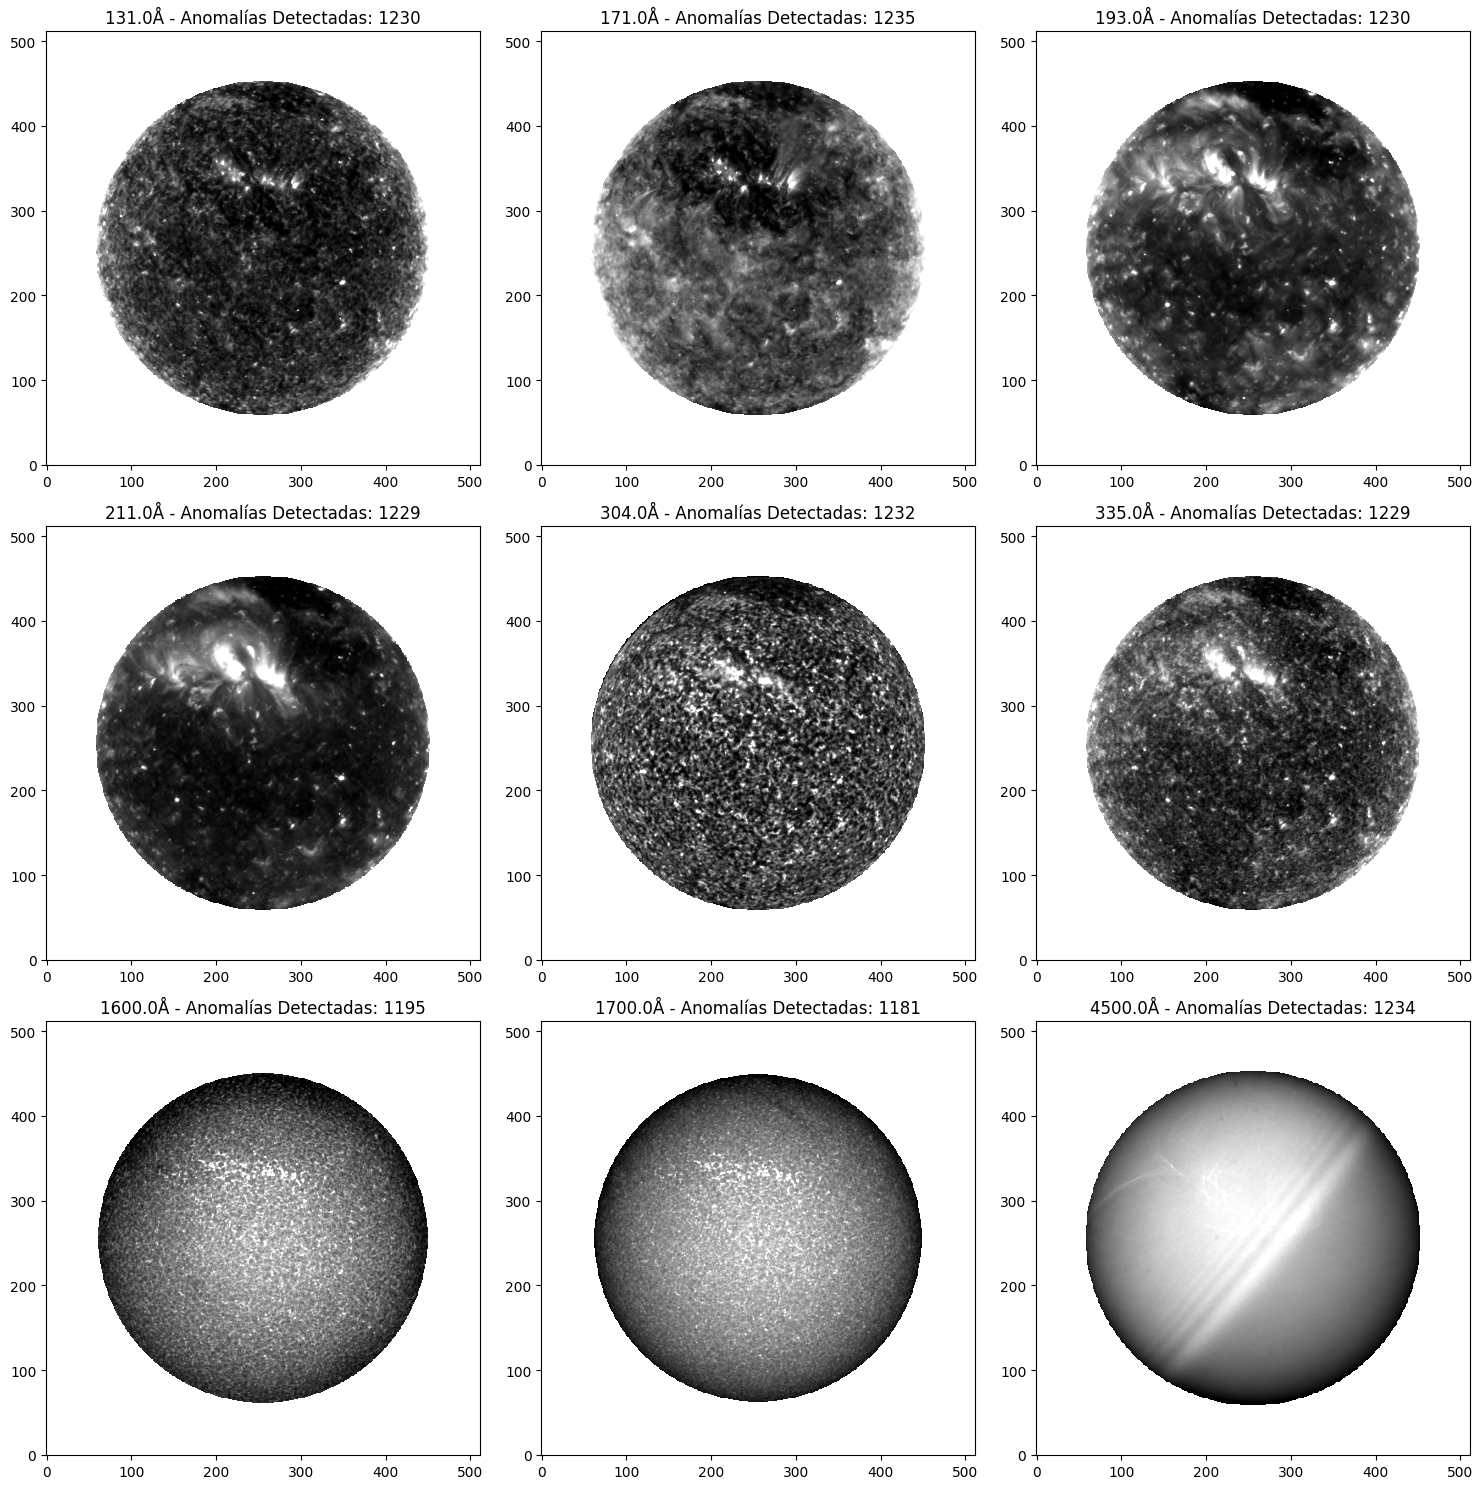

In [71]:
# Función para graficar anomalías con colores personalizados
def plot_anomalies(ax, channel, masked_data, anomalies):
    """
    Grafica las anomalías detectadas en la imagen original.
    """
    # Crear una máscara para las anomalías
    anomaly_mask = np.zeros_like(masked_data, dtype=bool)
    anomaly_mask[~np.isnan(masked_data)] = anomalies == -1  # -1 indica anomalías en LOF
    
    # Contar el número de anomalías detectadas
    num_anomalies = np.sum(anomalies == -1)
    
    # Graficar la imagen original en escala de grises
    ax.imshow(masked_data, origin="lower", cmap="gray", vmin=np.nanpercentile(masked_data, 1), vmax=np.nanpercentile(masked_data, 99))
    
    # Resaltar las anomalías en color (por ejemplo, rojo)
    ax.imshow(np.ma.masked_where(~anomaly_mask, anomaly_mask), 
              origin="lower", cmap="Reds", alpha=0.9)  # Rojo intenso con alta opacidad
    
    # Agregar título con el número de anomalías detectadas
    ax.set_title(f"{channel} - Anomalías Detectadas: {num_anomalies}", color="black")

# Crear figura para mostrar los canales
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Procesar cada canal y graficar anomalías
for i, channel in enumerate(channel_properties.keys()):
    channel_dir = os.path.join(base_data_path, channel)  # Usar base_data_path
    try:
        # Cargar datos y metadatos
        channel_data, metadata = load_fits_data(channel_dir)
        print(f"Channel: {channel}, Data Stats: min={np.nanmin(channel_data)}, max={np.nanmax(channel_data)}")
        
        # Crear máscara circular
        mask = create_circular_mask(channel_data, metadata)
        
        # Preprocesar la imagen
        masked_data = preprocess_image(channel_data, mask)
        
        # Preparar datos para LOF
        prepared_data = prepare_data(masked_data)
        
        # Entrenar el modelo LOF con los mejores parámetros
        anomalies, outlier_scores = train_lof_with_best_params(prepared_data, contamination=0.01, n_neighbors=10)
        
        # Graficar anomalías
        plot_anomalies(axes[i], channel, masked_data, anomalies)
        
    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing channel {channel}: {e}")
        axes[i].set_title(f"{channel} (Error)", color="black")
        axes[i].axis("off")

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

Files in directory: ['171.0Å', '131.0Å', '211.0Å', '1700.0Å', '304.0Å', '4500.0Å', '335.0Å', '1600.0Å', '193.0Å']
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0400545597076416
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.041012167930603
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0405596494674683
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0403803586959839
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0392675399780273
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0405789613723755
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0407488346099854
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0391005277633667
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0405532121658325


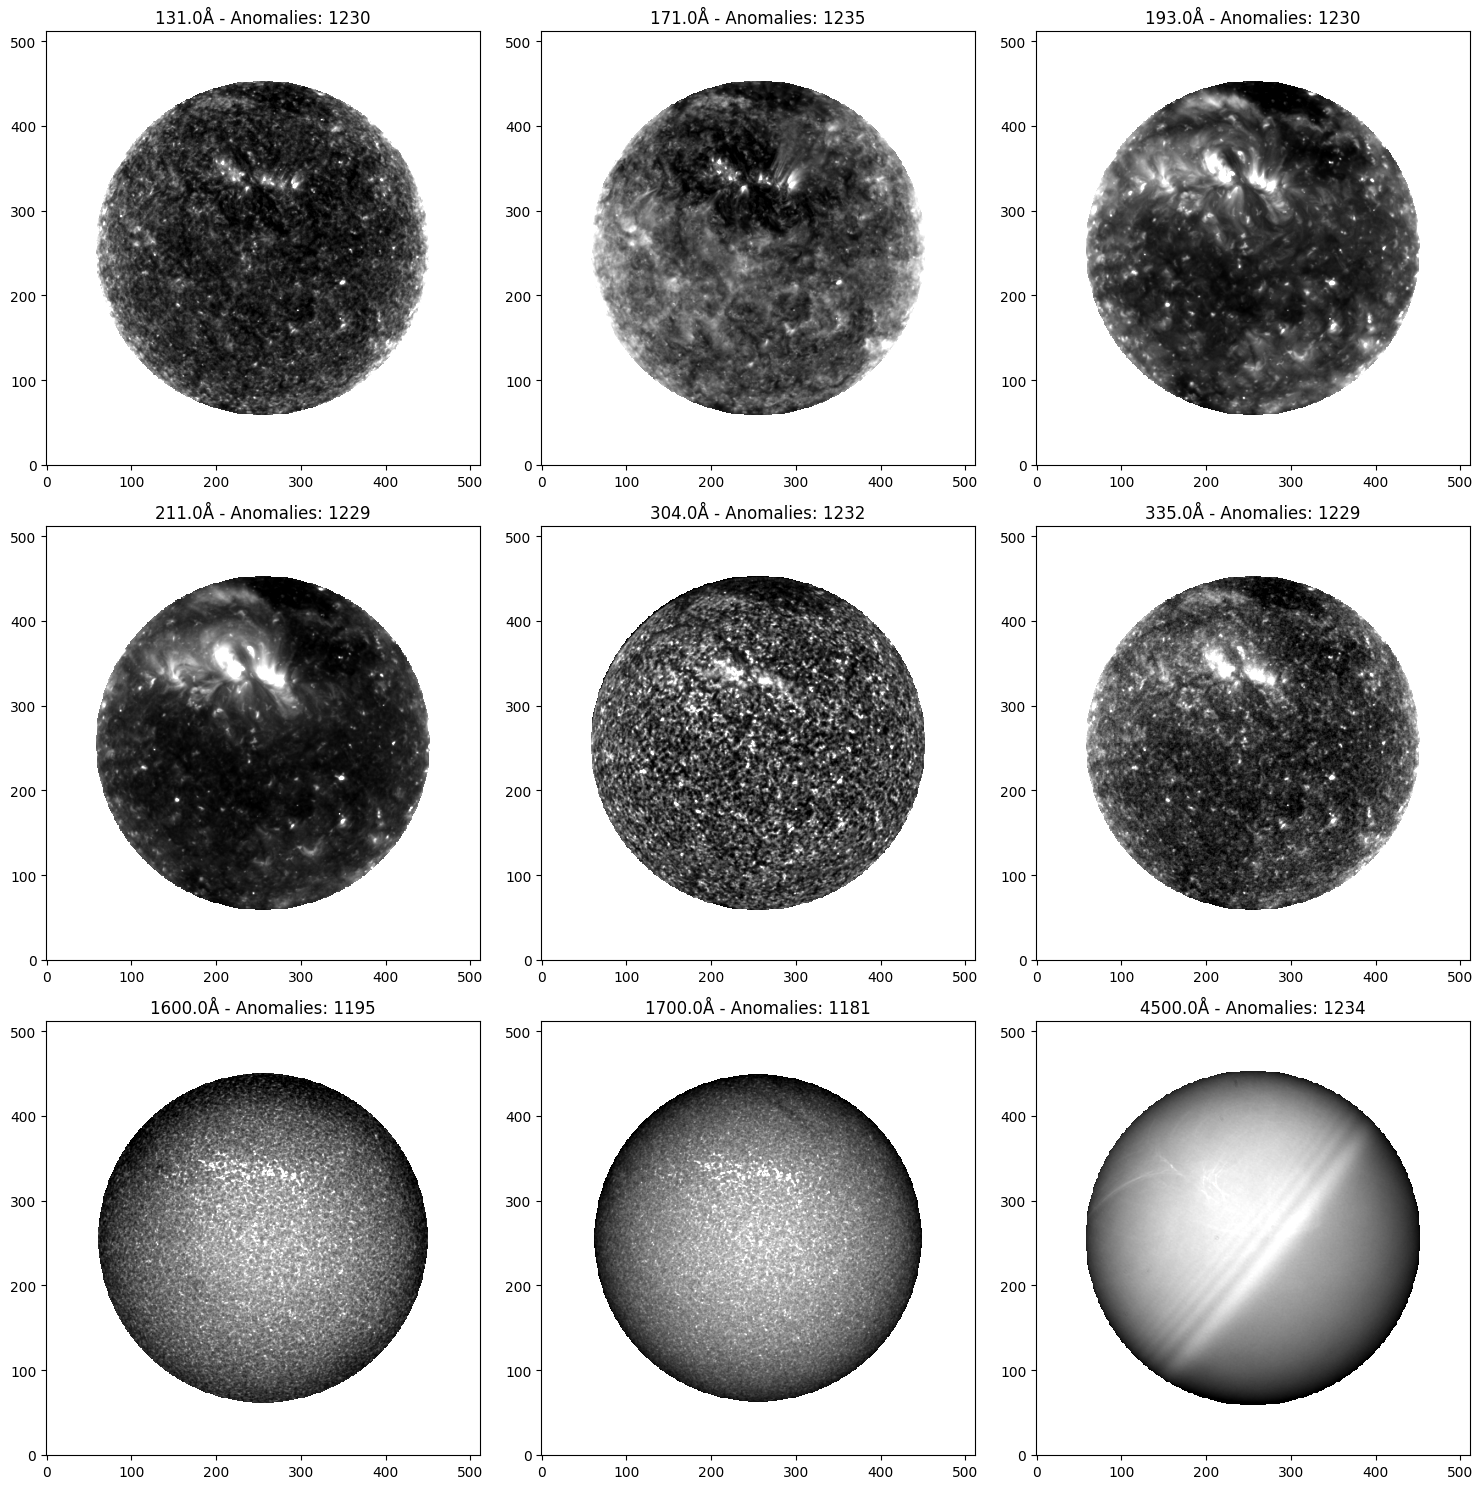

In [74]:
def preprocess_image(data: np.ndarray, mask: np.ndarray, size: int = 512) -> np.ndarray:
    resized_data = resize(data, (size, size), mode="reflect", anti_aliasing=True)
    resized_mask = resize(mask, (size, size), mode="reflect", anti_aliasing=False) > 0.5
    masked_data = resized_data.copy()
    masked_data[~resized_mask] = np.nan
    return masked_data

def prepare_data(masked_data):
    if np.isnan(masked_data).all():
        raise ValueError("All data is masked (NaN). No valid data to process.")

    flattened_data = masked_data[~np.isnan(masked_data)].reshape(-1, 1)
    if flattened_data.size == 0:
        raise ValueError("No valid data after removing NaN.")

    scaler = RobustScaler()
    return scaler.fit_transform(flattened_data)

def tune_lof_parameters(data):
    param_grid = {
        'n_neighbors': [10, 20, 30],
        'contamination': [0.01, 0.05, 0.1]
    }
    best_params, best_score = None, -np.inf

    for params in ParameterGrid(param_grid):
        lof = LocalOutlierFactor(n_neighbors=params['n_neighbors'], contamination=params['contamination'])
        anomalies = lof.fit_predict(data)
        score = np.mean(-lof.negative_outlier_factor_)
        if score > best_score:
            best_score, best_params = score, params

    print(f"Best params: {best_params} with score: {best_score}")
    return best_params

def train_lof_with_best_params(data, contamination, n_neighbors):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    lof.fit(data)
    anomalies = lof.fit_predict(data)
    return anomalies, -lof.negative_outlier_factor_

def plot_anomalies(ax, channel, masked_data, anomalies):
    anomaly_mask = np.zeros_like(masked_data, dtype=bool)
    anomaly_mask[~np.isnan(masked_data)] = anomalies == -1
    num_anomalies = np.sum(anomalies == -1)

    ax.imshow(masked_data, origin="lower", cmap="gray", vmin=np.nanpercentile(masked_data, 1), vmax=np.nanpercentile(masked_data, 99))
    ax.imshow(np.ma.masked_where(~anomaly_mask, anomaly_mask), origin="lower", cmap="Reds", alpha=0.8)
    ax.set_title(f"{channel} - Anomalies: {num_anomalies}", color="black")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, channel in enumerate(channel_properties.keys()):
    channel_dir = os.path.join(base_data_path, channel)
    try:
        channel_data, metadata = load_fits_data(channel_dir)
        mask = create_circular_mask(channel_data, metadata)
        masked_data = preprocess_image(channel_data, mask)
        prepared_data = prepare_data(masked_data)

        best_params = tune_lof_parameters(prepared_data)
        anomalies, _ = train_lof_with_best_params(prepared_data, **best_params)
        plot_anomalies(axes[i], channel, masked_data, anomalies)
    except Exception as e:
        print(f"Error processing channel {channel}: {e}")
        axes[i].set_title(f"{channel} (Error)", color="black")
        axes[i].axis("off")

plt.tight_layout()
plt.show()


# Evaluación del Modelo

Es importante evaluar el rendimiento del modelo para asegurarte de que está detectando anomalías de manera efectiva. Dado que estás trabajando con datos no etiquetados, puedes usar métricas como:

Precisión y Recall: Si tienes alguna forma de validar manualmente las anomalías detectadas.

Curva ROC: Para evaluar la capacidad del modelo para distinguir entre normales y anomalías.

Files in directory: ['171.0Å', '131.0Å', '211.0Å', '1700.0Å', '304.0Å', '4500.0Å', '335.0Å', '1600.0Å', '193.0Å']
Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0400545597076416
Total data points: 122976
Number of anomalies detected: 1230
Anomaly proportion: 1.00%
Anomaly score summary:
count    122976.000000
mean          1.040055
std           0.096479
min           0.855236
25%           0.985145
50%           1.014123
75%           1.062356
max           6.631455
dtype: float64


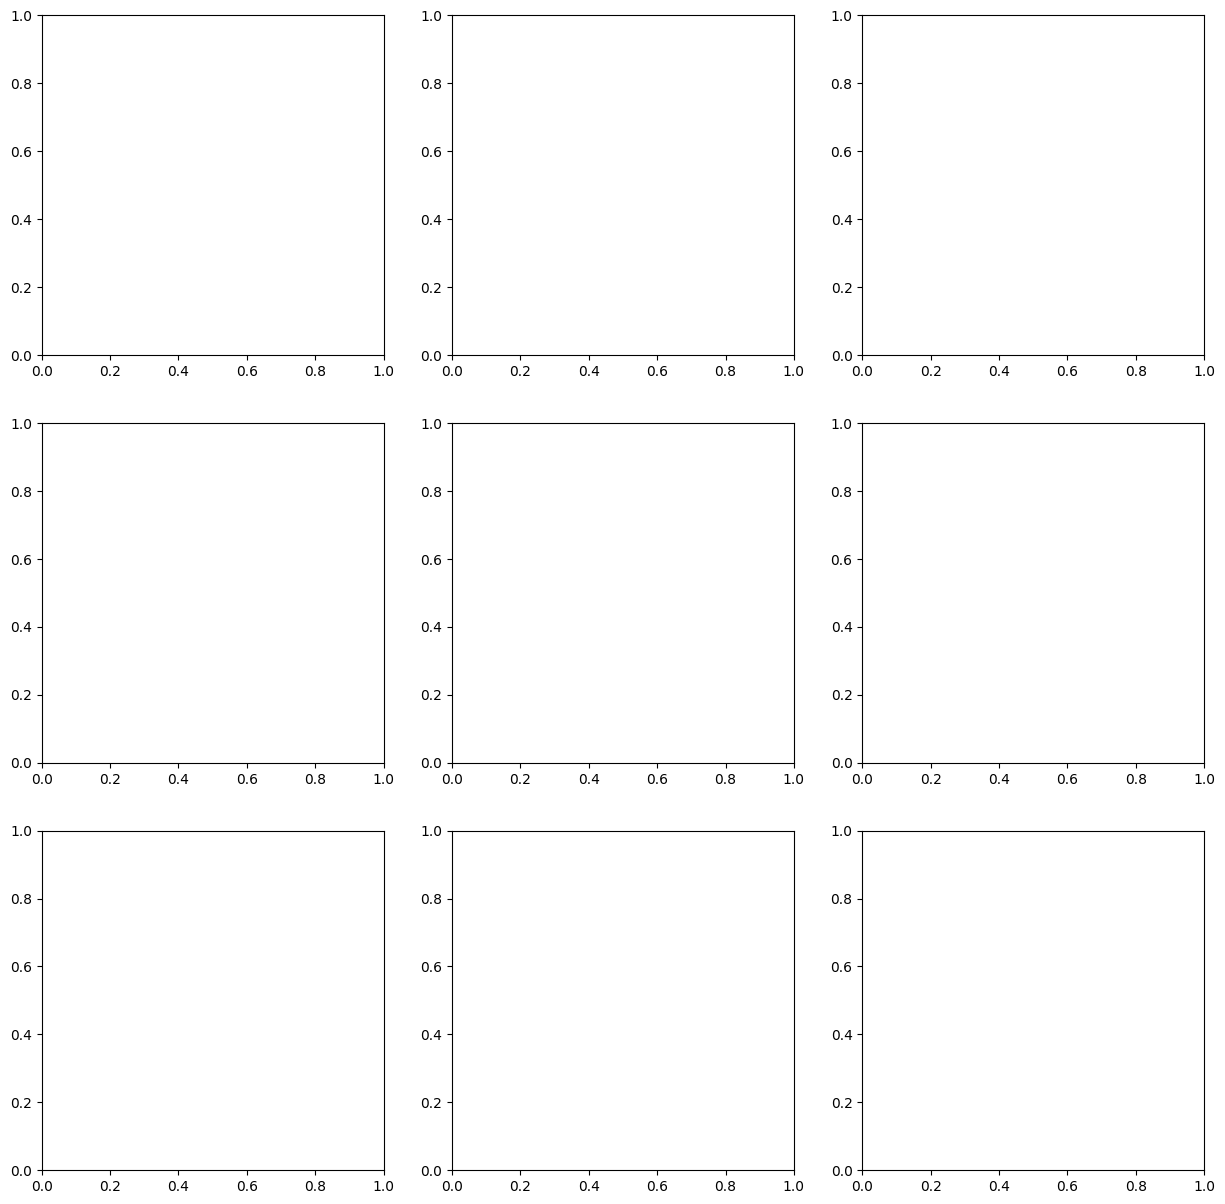

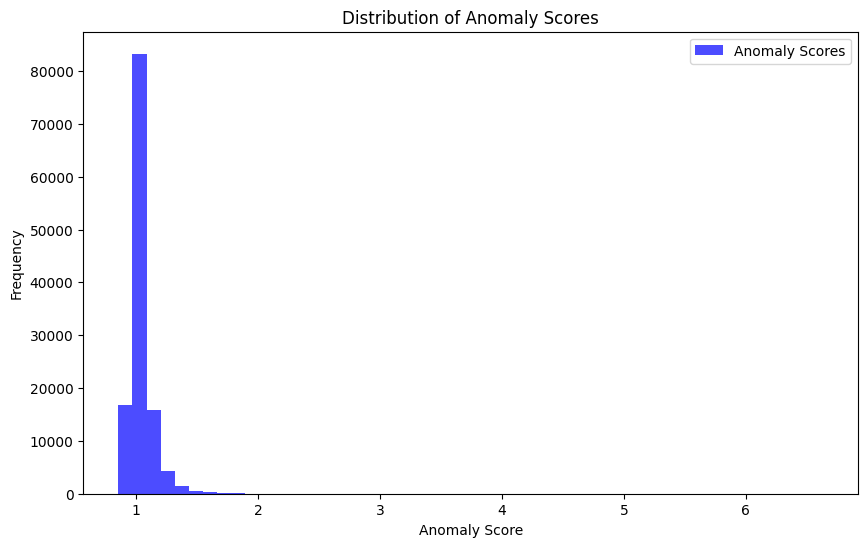

Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.041012167930603
Total data points: 123440
Number of anomalies detected: 1235
Anomaly proportion: 1.00%
Anomaly score summary:
count    123440.000000
mean          1.041012
std           0.097622
min           0.854253
25%           0.984506
50%           1.014430
75%           1.064297
max           3.997845
dtype: float64


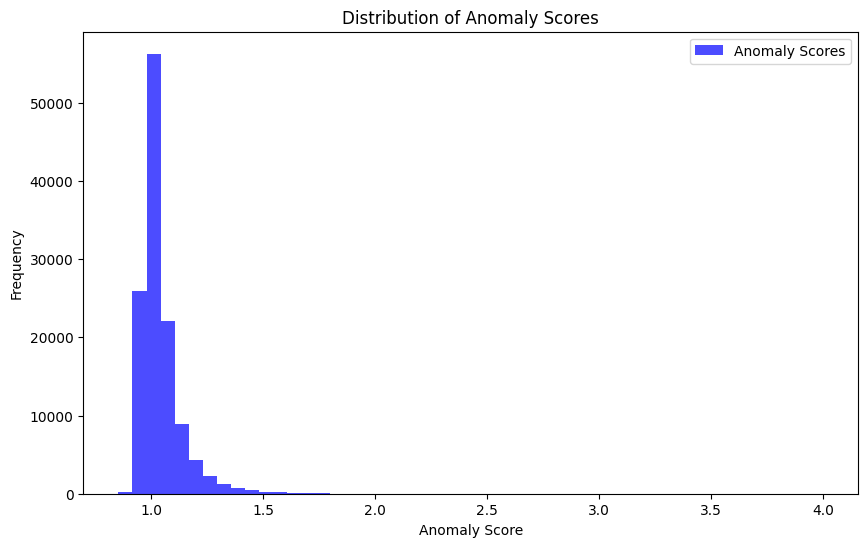

Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0405596494674683
Total data points: 122976
Number of anomalies detected: 1230
Anomaly proportion: 1.00%
Anomaly score summary:
count    122976.000000
mean          1.040560
std           0.096845
min           0.870976
25%           0.984653
50%           1.013879
75%           1.062834
max           3.041717
dtype: float64


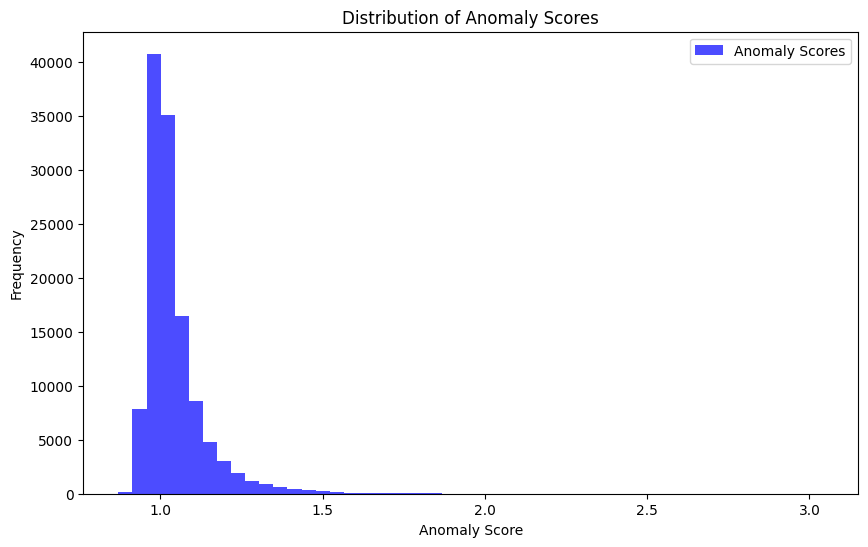

Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0403803586959839
Total data points: 122888
Number of anomalies detected: 1229
Anomaly proportion: 1.00%
Anomaly score summary:
count    122888.000000
mean          1.040380
std           0.096745
min           0.869340
25%           0.984514
50%           1.013890
75%           1.062679
max           3.050631
dtype: float64


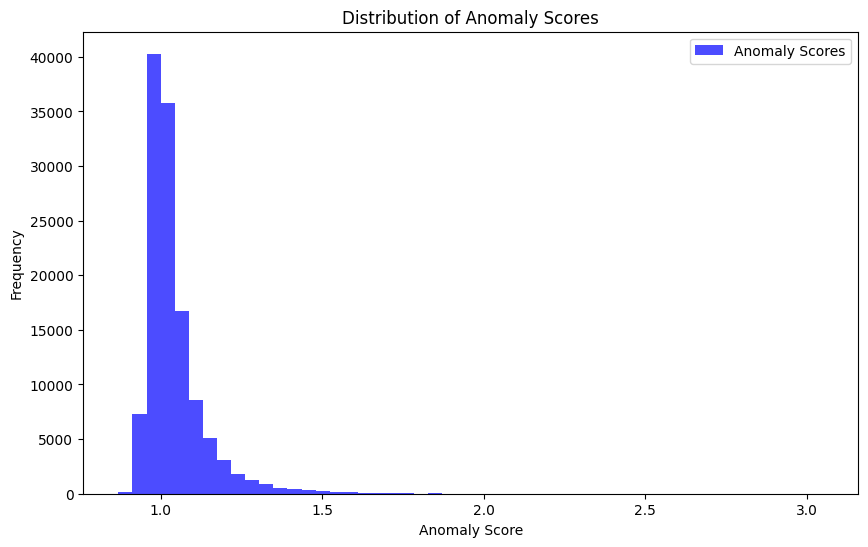

Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0392675399780273
Total data points: 123160
Number of anomalies detected: 1232
Anomaly proportion: 1.00%
Anomaly score summary:
count    123160.000000
mean          1.039268
std           0.095114
min           0.859841
25%           0.984579
50%           1.013976
75%           1.061696
max           4.643478
dtype: float64


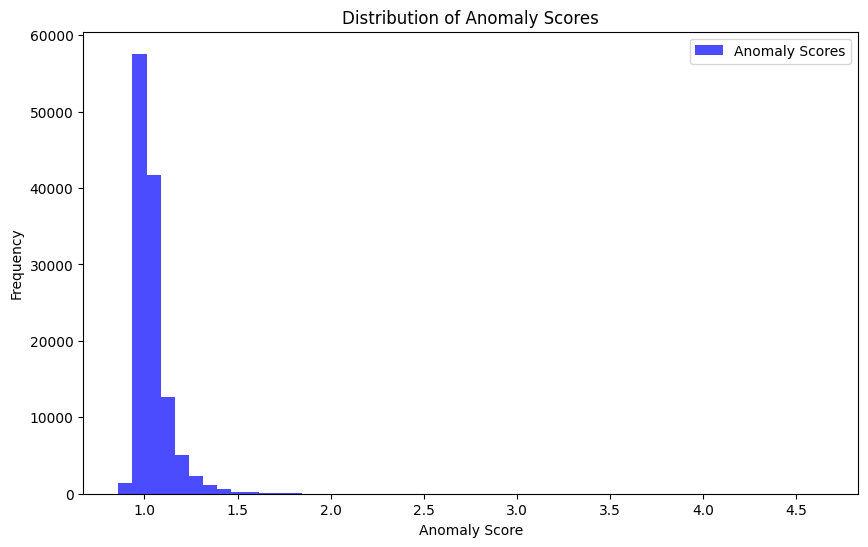

Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0405789613723755
Total data points: 122888
Number of anomalies detected: 1229
Anomaly proportion: 1.00%
Anomaly score summary:
count    122888.000000
mean          1.040579
std           0.096383
min           0.859891
25%           0.984625
50%           1.013993
75%           1.062919
max           3.589541
dtype: float64


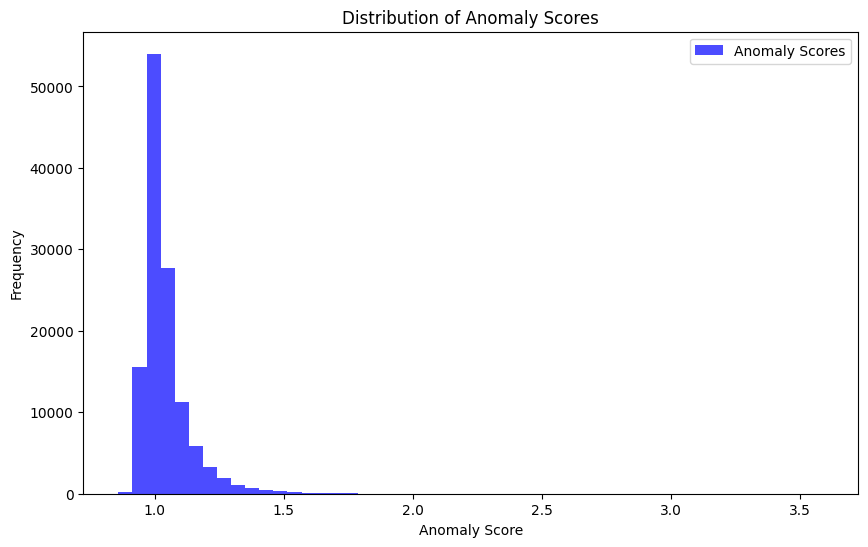

Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0407488346099854
Total data points: 119488
Number of anomalies detected: 1195
Anomaly proportion: 1.00%
Anomaly score summary:
count    119488.000000
mean          1.040749
std           0.096459
min           0.878042
25%           0.984524
50%           1.013920
75%           1.063614
max           2.891276
dtype: float64


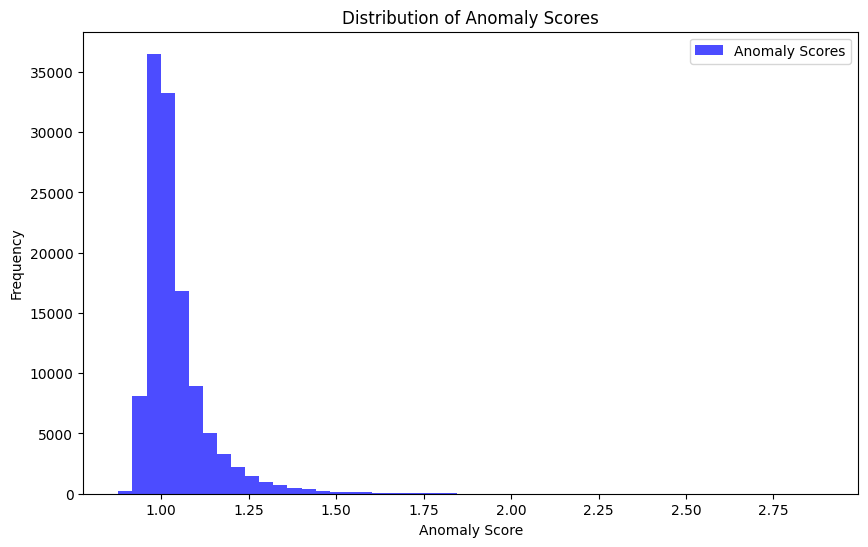

Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0391005277633667
Total data points: 118084
Number of anomalies detected: 1181
Anomaly proportion: 1.00%
Anomaly score summary:
count    118084.000000
mean          1.039101
std           0.093218
min           0.872788
25%           0.984484
50%           1.013853
75%           1.061615
max           2.398620
dtype: float64


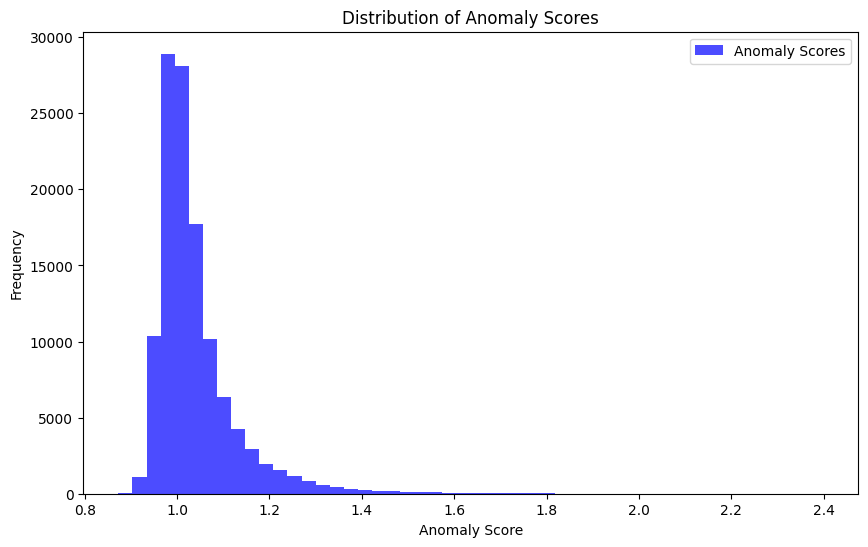

Best params: {'contamination': 0.01, 'n_neighbors': 10} with score: 1.0405532121658325
Total data points: 123328
Number of anomalies detected: 1234
Anomaly proportion: 1.00%
Anomaly score summary:
count    123328.000000
mean          1.040553
std           0.097763
min           0.871144
25%           0.984763
50%           1.014525
75%           1.063674
max           4.388317
dtype: float64


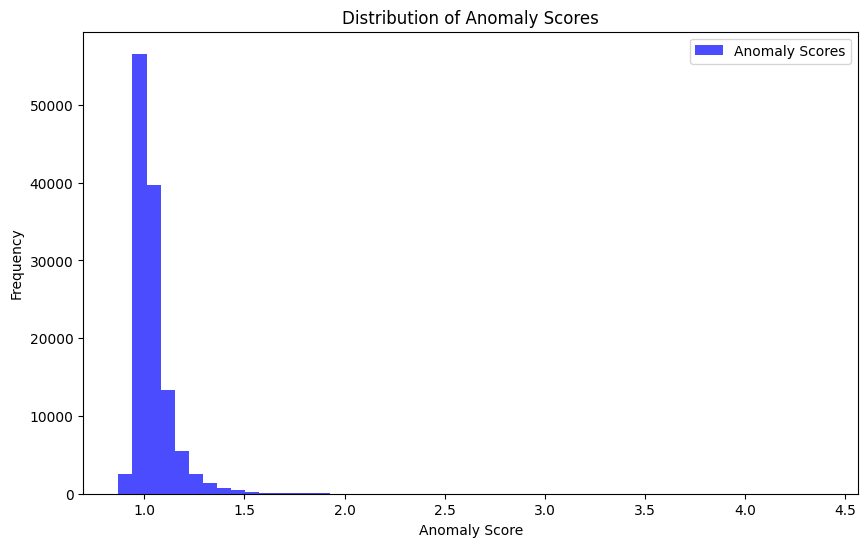

<Figure size 640x480 with 0 Axes>

In [78]:
def create_circular_mask(data, metadata):
    ny, nx = data.shape
    x_center, y_center = nx // 2, ny // 2
    cdelt1 = metadata.get("cdelt1", 1.0)
    solar_radius_arcsec = metadata.get("rsun_obs", 960.0)
    solar_radius_pixels = int(solar_radius_arcsec / abs(cdelt1))

    y, x = np.ogrid[:ny, :nx]
    distance_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    mask = distance_from_center <= solar_radius_pixels
    return mask

def preprocess_image(data: np.ndarray, mask: np.ndarray, size: int = 512) -> np.ndarray:
    resized_data = resize(data, (size, size), mode="reflect", anti_aliasing=True)
    resized_mask = resize(mask, (size, size), mode="reflect", anti_aliasing=False) > 0.5
    masked_data = resized_data.copy()
    masked_data[~resized_mask] = np.nan
    return masked_data

def prepare_data(masked_data):
    if np.isnan(masked_data).all():
        raise ValueError("All data is masked (NaN). No valid data to process.")

    flattened_data = masked_data[~np.isnan(masked_data)].reshape(-1, 1)
    if flattened_data.size == 0:
        raise ValueError("No valid data after removing NaN.")

    scaler = RobustScaler()
    return scaler.fit_transform(flattened_data)

def tune_lof_parameters(data):
    param_grid = {
        'n_neighbors': [10, 20, 30],
        'contamination': [0.01, 0.05, 0.1]
    }
    best_params, best_score = None, -np.inf

    for params in ParameterGrid(param_grid):
        lof = LocalOutlierFactor(n_neighbors=params['n_neighbors'], contamination=params['contamination'])
        anomalies = lof.fit_predict(data)
        score = np.mean(-lof.negative_outlier_factor_)
        if score > best_score:
            best_score, best_params = score, params

    print(f"Best params: {best_params} with score: {best_score}")
    return best_params

def train_lof_with_best_params(data, contamination, n_neighbors):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    lof.fit(data)
    anomalies = lof.fit_predict(data)
    return anomalies, -lof.negative_outlier_factor_

def evaluate_model(data, anomalies, scores):
    num_anomalies = np.sum(anomalies == -1)
    print(f"Total data points: {len(data)}")
    print(f"Number of anomalies detected: {num_anomalies}")
    
    if num_anomalies > 0:
        print(f"Anomaly proportion: {num_anomalies / len(data):.2%}")
        print("Anomaly score summary:")
        print(pd.Series(scores).describe())
    else:
        print("No anomalies detected.")

    # Plot anomaly scores
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, color='blue', alpha=0.7, label='Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Anomaly Scores')
    plt.legend()
    plt.show()

def plot_anomalies(ax, channel, masked_data, anomalies):
    if np.isnan(masked_data).all():
        ax.set_title(f"{channel} (All Data Masked)", color="red")
        ax.axis("off")
        return

    anomaly_mask = np.zeros_like(masked_data, dtype=bool)
    anomaly_mask[~np.isnan(masked_data)] = anomalies == -1
    num_anomalies = np.sum(anomalies == -1)

    ax.imshow(masked_data, origin="lower", cmap="gray", vmin=np.nanpercentile(masked_data, 1), vmax=np.nanpercentile(masked_data, 99))
    if num_anomalies > 0:
        ax.imshow(np.ma.masked_where(~anomaly_mask, anomaly_mask), origin="lower", cmap="Reds", alpha=0.8)
    ax.set_title(f"{channel} - Anomalies: {num_anomalies}", color="black")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, channel in enumerate(channel_properties.keys()):
    channel_dir = os.path.join(base_data_path, channel)
    try:
        channel_data, metadata = load_fits_data(channel_dir)
        mask = create_circular_mask(channel_data, metadata)
        masked_data = preprocess_image(channel_data, mask)

        if np.isnan(masked_data).all():
            print(f"Channel {channel}: All data masked.")
            axes[i].set_title(f"{channel} (All Data Masked)", color="red")
            axes[i].axis("off")
            continue

        prepared_data = prepare_data(masked_data)
        best_params = tune_lof_parameters(prepared_data)
        anomalies, scores = train_lof_with_best_params(prepared_data, **best_params)

        evaluate_model(prepared_data, anomalies, scores)
        plot_anomalies(axes[i], channel, masked_data, anomalies)
    except Exception as e:
        print(f"Error processing channel {channel}: {e}")
        axes[i].set_title(f"{channel} (Error)", color="red")
        axes[i].axis("off")

plt.tight_layout()
plt.show()
